In [1]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/zcapjru/PhD/DEScls/xcell/mappers')


from mapper_base import MapperBase
from astropy.io import fits
from astropy.table import Table

import mapper_eBOSSQSO
import mapper_P15CMBK
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp

In [2]:
# Initialize binning scheme with 20 ells per bandpower
nside = 512
nside_mask = 512

ells = []
i = 11.5
while i <= 3 * nside:
    ells.append(round(i))
    #i = i*(1+i/(3 * nside))
    i = i+20*(1+i/240)
    
if ells[-1] <  3 * nside -1:   
    ells.append(3 * nside -1)
    
ells = np.array(ells)


scale_cut = 1000
ells = ells[ells < scale_cut]

if ells[-1] < scale_cut:
    ells = np.append(ells, scale_cut)
    
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()
print(ell_arr)

[ 21.5  43.   67.   92.5 120.  150.5 183.  218.  256.5 298.  343.  391.5
 444.  501.  563.  630.  702.5 781.  866.  955. ]


In [3]:
NGC_1_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_data-NGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_random-NGC-vDR16.fits'],
          'z_edges':[0, 1.5],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_NGC_1' }

NGC_2_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_data-NGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_random-NGC-vDR16.fits'],
          'z_edges':[1.5, 3],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_NGC_2'  }

SGC_1_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_data-SGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_random-SGC-vDR16.fits'],
          'z_edges':[0.01, 1.5],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_SGC_1' }

SGC_2_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_data-SGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_random-SGC-vDR16.fits'],
          'z_edges':[1.5, 3],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_SGC_1'  }

CMBK_config = {'file_klm':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/dat_klm.fits', 
          'file_mask':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/mask.fits.gz',
               'file_noise':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/nlkk.dat', 'mask_name': 3,
          'nside':nside}

In [4]:
b_arr = np.linspace(0, 5, 100)
zbin = 2
mode = 'SGC'
only_gg = False
only_gk = True

maps_k = mapper_P15CMBK.MapperP15CMBK(CMBK_config)
maps_1 = mapper_eBOSSQSO.MappereBOSSQSO(SGC_1_config)
maps_2 = mapper_eBOSSQSO.MappereBOSSQSO(SGC_2_config)

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [5]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)

nz_1 = maps_1.get_nz()
nz_2 = maps_2.get_nz()

nzs = {
    'z_1'    : nz_1[1],
    'dNdz_1' : nz_1[0],
    'z_2'    : nz_2[1],
    'dNdz_2' : nz_2[0]
}

z_1 = nz_1[1]
dNdz_1 = nz_1[0]

z_2 = nz_2[1]
dNdz_2 = nz_2[0]

In [6]:
def get_cov_wsp(f1, f2, f3 = None, f4 = None):
    cw = nmt.NmtCovarianceWorkspace()
    cw.compute_coupling_coefficients(f1, f2, f3, f4)
    return cw

def get_cov(cl1, cl2, cl3, cl4, cw, wa, wb):
    return  nmt.gaussian_covariance(cw,
                                      0, 0, 0, 0,  # Spins of the 4 fields
                                      cl1,  # TT
                                      cl2,  # TT
                                      cl3,  # TT
                                      cl4,  # TT
                                      wa, wb=wb)

In [7]:
m1 = maps_1.get_mask()
m2 = maps_2.get_mask()

f1 = maps_1.get_nmt_field()
f2 = maps_1.get_nmt_field()

w_11 = nmt.NmtWorkspace()
w_11.compute_coupling_matrix(f1, f1, bands)
      
w_12 = nmt.NmtWorkspace()
w_12.compute_coupling_matrix(f1, f2, bands)

w_22 = nmt.NmtWorkspace()
w_22.compute_coupling_matrix(f2, f2, bands)

#everything decoupled
nl11 =  w_11.decouple_cell(maps_1.get_nl_coupled())
nl22 =  w_22.decouple_cell(maps_2.get_nl_coupled())
nl12 = [np.zeros_like(nl11)]
nl21 = [np.zeros_like(nl11)]

cw_1111 = get_cov_wsp(f1, f1)
cw_2222 = get_cov_wsp(f2, f2)

cl = nmt.compute_coupled_cell(f1, f1)/ np.mean(m1 * m1)
cov_1111 = get_cov(cl, cl, cl, cl, cw_1111, w_11, w_11)

cl = nmt.compute_coupled_cell(f2, f2)/ np.mean(m2 * m2)
cov_2222 = get_cov(cl, cl, cl, cl, cw_2222, w_22, w_22)

err_11 = np.sqrt(cov_1111.diagonal())
err_22 = np.sqrt(cov_2222.diagonal())

In [8]:
mk = maps_k.get_mask()
fk = maps_k.get_nmt_field()

w_k1 = nmt.NmtWorkspace()
w_k1.compute_coupling_matrix(f1, fk, bands)

w_k2 = nmt.NmtWorkspace()
w_k2.compute_coupling_matrix(f2, fk, bands)

w_kk = nmt.NmtWorkspace()
w_kk.compute_coupling_matrix(fk, fk, bands)

cw_1k1k = get_cov_wsp(f1, fk)
cw_111k = get_cov_wsp(f1, f1, f1, fk)
cw_222k = get_cov_wsp(f2, f2, f2, fk)
cw_2k2k = get_cov_wsp(f2, fk)

cl11 = nmt.compute_coupled_cell(f1, f1)/ np.mean(m1 * m1)
cl1k = nmt.compute_coupled_cell(f1, fk)/ np.mean(m1 * mk)
clk1 = nmt.compute_coupled_cell(fk, f1)/ np.mean(mk * m1)
clkk = nmt.compute_coupled_cell(fk, fk)/ np.mean(mk * mk)
cov_1k1k = get_cov(cl11, cl1k, clk1, clkk, cw_1k1k, w_k1, w_k1)

cl11 = nmt.compute_coupled_cell(f1, f1)/ np.mean(m1 * m1)
cl1k = nmt.compute_coupled_cell(f1, fk)/ np.mean(m1 * mk)
cov_111k = get_cov(cl11, cl1k, cl11, cl1k, cw_111k, w_11, w_k1)

cl22 = nmt.compute_coupled_cell(f2, f2)/ np.mean(m2 * m2)
cl2k = nmt.compute_coupled_cell(f2, fk)/ np.mean(m2 * mk)
cov_222k = get_cov(cl22, cl2k, cl22, cl2k, cw_222k, w_22, w_k2)

cl22 = nmt.compute_coupled_cell(f2, f2)/ np.mean(m2 * m2)
cl2k = nmt.compute_coupled_cell(f2, fk)/ np.mean(m2 * mk)
clk2 = nmt.compute_coupled_cell(fk, f2)/ np.mean(mk * m2)
clkk = nmt.compute_coupled_cell(fk, fk)/ np.mean(mk * mk)
cov_2k2k = get_cov(cl22, cl2k, clk2, clkk, cw_2k2k, w_k2, w_k2)

err_1k = np.sqrt(cov_1k1k.diagonal())
err_2k = np.sqrt(cov_2k2k.diagonal())

In [9]:
sel = ell_arr < scale_cut
cl11 = w_11.decouple_cell(nmt.compute_coupled_cell(f1, f1))[0] - nl11[0]
cl1k = w_k1.decouple_cell(nmt.compute_coupled_cell(f1, fk))[0] 
data_1 = np.zeros(2*len(cl11))
data_1[:len(cl11)] =  cl11
data_1[len(cl11):] =  cl1k

cl22 = w_22.decouple_cell(nmt.compute_coupled_cell(f2, f2))[0] - nl22[0]
cl2k = w_k2.decouple_cell(nmt.compute_coupled_cell(f2, fk))[0]
data_2 = np.zeros(2*len(cl22))
data_2[:len(cl22)] =  cl22
data_2[len(cl22):] =  cl2k

In [10]:
nls = {
    'nl11': nl11[0],
    'nl22': nl22[0]
}

cls = {
    'cl11': cl11,
    'cl1k': cl1k,
    'cl22': cl22, 
    'cl2k': cl2k
}

errors = {
    'err_11': err_11,
    'err_22': err_22,
    'err_1k': err_1k,
    'err_2k': err_2k
}

In [11]:
def build_comp_cov(cov_aaaa, cov_aaab, cov_aabb):
    cov_abaa = np.transpose(cov_aaab)
    dim = len(cov_aaaa)
    comp_cov = np.zeros([2*dim, 2*dim])
    comp_cov[:dim,:dim] = cov_aaaa
    comp_cov[:dim,dim:] = cov_aaab
    comp_cov[dim:,:dim] = cov_abaa
    comp_cov[dim:,dim:] = cov_aabb
    return comp_cov

In [12]:
comp_cov_1 = build_comp_cov(cov_1111, cov_111k, cov_1k1k)
comp_cov_2 = build_comp_cov(cov_2222, cov_222k, cov_2k2k)

In [13]:
covs = {
    'comp_cov_1': comp_cov_1,
    'comp_cov_2': comp_cov_2
}

datas = {
    'data_1': data_1,
    'data_2': data_2
}

In [14]:
def theory(z, dNdz, b):
    b = b*np.ones(len(z))
    quasar = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, dNdz), bias=(z,b))
    CMB_shear = ccl.CMBLensingTracer(cosmo, 1100)
    clgg = ccl.angular_cl(cosmo, quasar, quasar, ell_arr)
    clgs = ccl.angular_cl(cosmo, quasar, CMB_shear, ell_arr)
    theory = np.zeros(2*len(clgg))
    theory[:len(clgg)] = clgg
    theory[len(clgg):] = clgs
    return theory

def gof(b, zbin):
    cov = covs['comp_cov_{}'.format(zbin)]
    inv_cov = np.linalg.inv(cov)
    d = datas['data_{}'.format(zbin)]
    t = theory(nzs['z_{}'.format(zbin)], nzs['dNdz_{}'.format(zbin)], b)
    if only_gg:
        d[int(len(d)/2):] = np.zeros(int(len(d)/2))
        t[int(len(d)/2):] = np.zeros(int(len(d)/2))  
    if only_gk:
        d[:int(len(d)/2)] = np.zeros(int(len(d)/2))
        t[:int(len(d)/2)] = np.zeros(int(len(d)/2)) 
    return np.transpose(d-t)@inv_cov@(d-t)

In [15]:
x2 = []
for item in b_arr:
    x2.append(gof(item, zbin))
x2 = np.array(x2)

pb = np.exp(-0.5*x2)
pb = pb/sum(pb)
best_b = b_arr[np.argmin(x2)]
best_x2 = min(x2)
mean_b = (sum(b_arr*pb))/(sum(pb))
sigma_b = np.sqrt((sum(np.abs(b_arr-mean_b)*pb))/(sum(pb)))
print(best_x2, best_b, mean_b, sigma_b)
print(len(datas['data_1']))

16.664100066805034 2.5757575757575757 2.571190646891646 0.6030624798986196
40


In [16]:
best_b = best_b*np.ones(len(z_1))
z = nzs['z_{}'.format(zbin)]
dNdz = nzs['dNdz_{}'.format(zbin)]

quasar = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z_1,best_b))
CMB_shear = ccl.CMBLensingTracer(cosmo, 1100)

theory_gg = ccl.angular_cl(cosmo, quasar, quasar, ell_arr)
theory_gk = ccl.angular_cl(cosmo, CMB_shear, quasar, ell_arr)

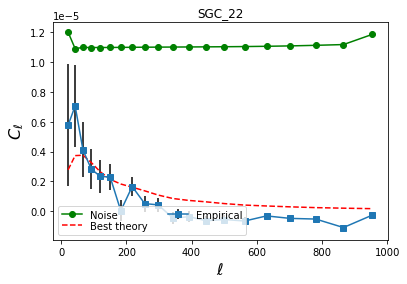

In [17]:
cl = cls['cl{}{}'.format(zbin,zbin)]
nl = nls['nl{}{}'.format(zbin,zbin)]
err = errors['err_{}{}'.format(zbin,zbin)]

plt.errorbar(ell_arr, cl, yerr=err, marker='s', ecolor='k', label='Empirical')
plt.plot(ell_arr, nl, 'go-', label='Noise')
plt.plot(ell_arr, theory_gg, 'r--', label='Best theory')


#plt.loglog()
#plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('{}_{}{}'.format(mode, zbin, zbin))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

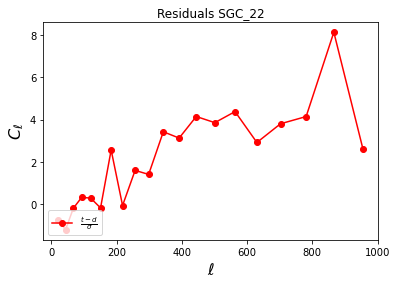

In [18]:
cl = cls['cl{}{}'.format(zbin,zbin)]
err = errors['err_{}{}'.format(zbin,zbin)]

plt.plot(ell_arr, (theory_gg-cl)/err, 'ro-', label=r'$\frac{t-d}{\sigma}$')
#plt.loglog()
#plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('Residuals {}_{}{}'.format(mode, zbin, zbin))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

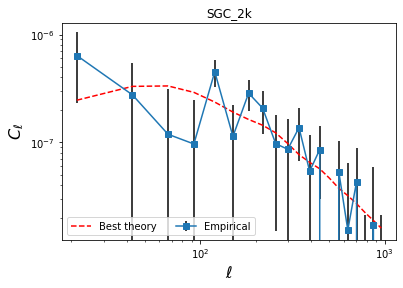

In [19]:
cl = cls['cl{}{}'.format(zbin,'k')]
err = errors['err_{}{}'.format(zbin,'k')]

plt.errorbar(ell_arr, cl, yerr=err, marker='s', ecolor='k', label='Empirical')
plt.plot(ell_arr, theory_gk, 'r--', label='Best theory')


plt.loglog()
#plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('{}_{}{}'.format(mode, zbin, 'k'))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

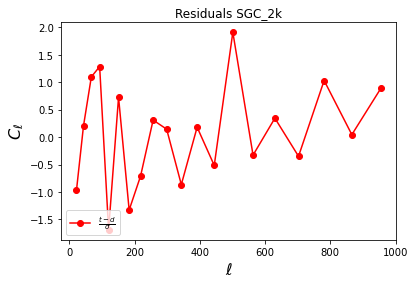

In [20]:
cl = cls['cl{}{}'.format(zbin,'k')]
err = errors['err_{}{}'.format(zbin,'k')]

plt.plot(ell_arr, (theory_gk-cl)/err, 'ro-', label=r'$\frac{t-d}{\sigma}$')

#plt.loglog()
#plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('Residuals {}_{}{}'.format(mode, zbin, 'k'))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

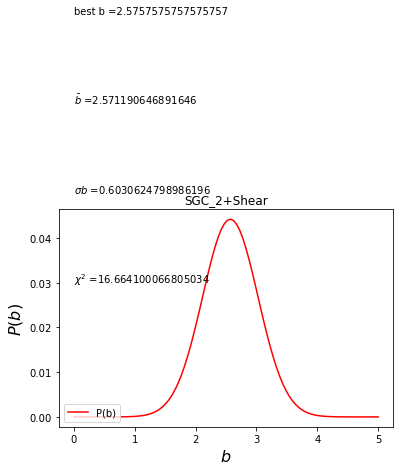

In [21]:
plt.plot(b_arr, pb, 'r-', label='P(b)')
plt.text(0, 0.09, 'best b ='+'{}'.format(best_b[0]))
plt.text(0, 0.07, r'$\bar{b}$ ='+'{}'.format(mean_b))
plt.text(0, 0.05, r'$\sigma b$ ='+'{}'.format(sigma_b))
plt.text(0, 0.03, r'$\chi^2$ ='+'{}'.format(best_x2))
plt.title('{}_{}+Shear'.format(mode, zbin))
plt.xlabel('$b$', fontsize=16)
plt.ylabel('$P(b)$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()